In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries



In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Data Organization Script

In [ ]:
import os
import shutil
import random

def create_train_test_splits(source_dir, dest_dir, train_ratio=0.8):
    """
    Create train and test splits from source directory.

    Parameters:
    source_dir: Directory containing class folders
    dest_dir: Directory where train and test splits will be created
    train_ratio: Ratio of files to use for training (default: 0.8)
    """

    # Create main directories if they don't exist
    train_dir = os.path.join(dest_dir, 'train')
    test_dir = os.path.join(dest_dir, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Get list of classes (folders)
    classes = [d for d in os.listdir(source_dir)
              if os.path.isdir(os.path.join(source_dir, d))]

    # Process each class
    for class_name in classes:
        print(f"\nProcessing class: {class_name}")

        # Create class directories in train and test
        train_class_dir = os.path.join(train_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        # Get list of all files in the class
        source_class_dir = os.path.join(source_dir, class_name)
        files = [f for f in os.listdir(source_class_dir)
                if os.path.isfile(os.path.join(source_class_dir, f))]

        # Randomly shuffle files
        random.shuffle(files)

        # Calculate split index
        split_idx = int(len(files) * train_ratio)
        train_files = files[:split_idx]
        test_files = files[split_idx:]

        # Copy files to train directory
        for f in train_files:
            src = os.path.join(source_class_dir, f)
            dst = os.path.join(train_class_dir, f)
            shutil.copy2(src, dst)

        # Copy files to test directory
        for f in test_files:
            src = os.path.join(source_class_dir, f)
            dst = os.path.join(test_class_dir, f)
            shutil.copy2(src, dst)

        print(f"Total files: {len(files)}")
        print(f"Training files: {len(train_files)}")
        print(f"Testing files: {len(test_files)}")

# Set up paths
source_directory = '/content/drive/MyDrive/Research Projects/Lung Cancer/The IQ-OTHNCCD lung cancer dataset'  # Update this to your source directory
destination_directory = '/content/drive/MyDrive/Research Projects/Lung Cancer/The IQ-OTHNCCD lung cancer dataset'  # Update this to where you want the split data

# Create the splits
create_train_test_splits(source_directory, destination_directory, train_ratio=0.8)

# Print final structure
def print_directory_structure(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f'{indent}{os.path.basename(root)}/')
        if level == 2:  # Only show counts for the deepest level
            print(f'{indent}    Files: {len(files)}')

print("\nFinal directory structure:")
print_directory_structure(destination_directory)

## Class distribution before Augmentation

Training Set Distribution:
--------------------------------------------------
Total images: 876
Malignant: 448 images (51.1%)
Normal: 332 images (37.9%)
Benign: 96 images (11.0%)

Testing Set Distribution:
--------------------------------------------------
Total images: 221
Malignant: 113 images (51.1%)
Normal: 84 images (38.0%)
Benign: 24 images (10.9%)


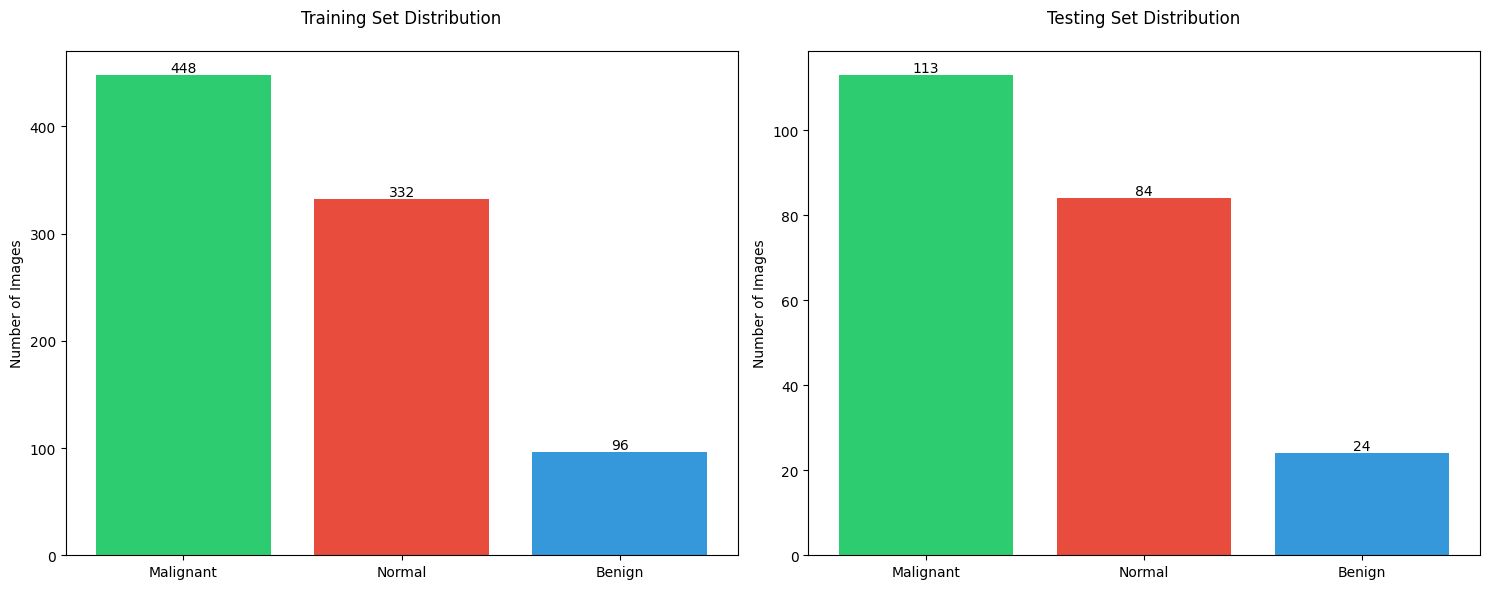

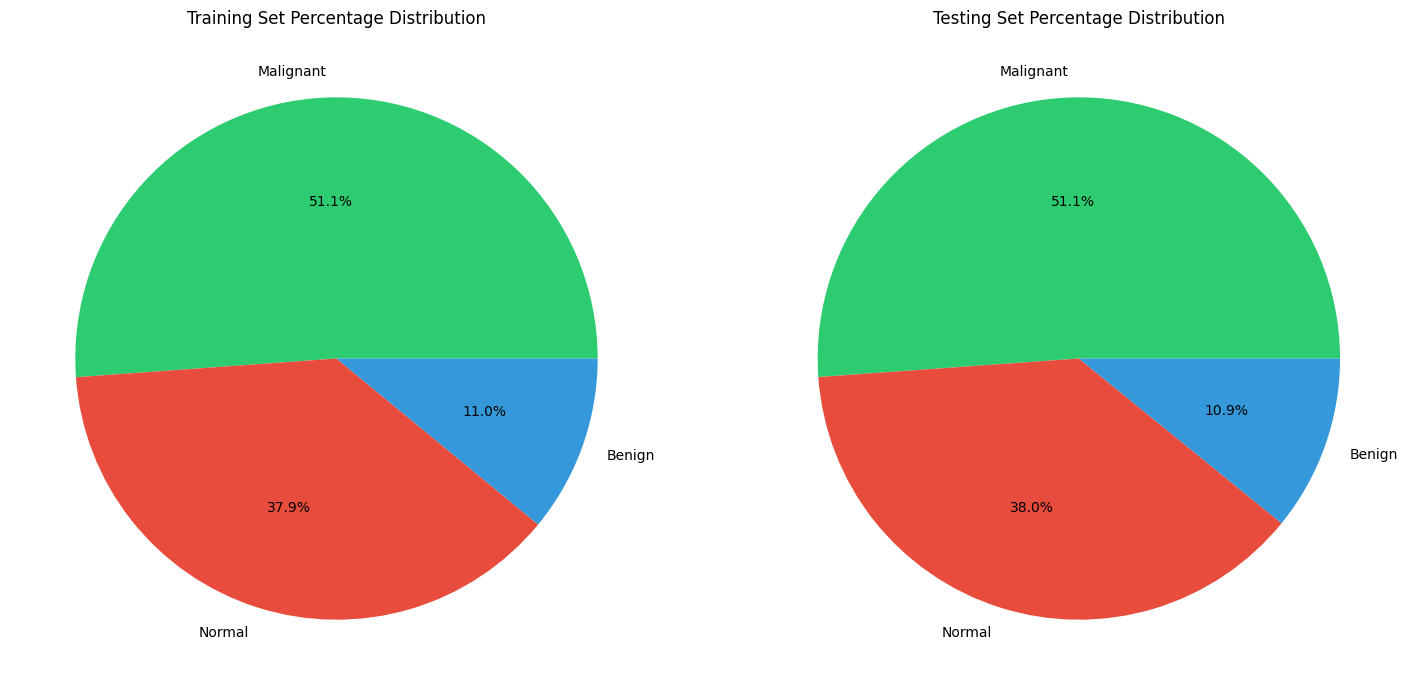


Class Ratios:
--------------------------------------------------
Training Set:
Malignant: 51.1%
Normal: 37.9%
Benign: 11.0%

Testing Set:
Malignant: 51.1%
Normal: 38.0%
Benign: 10.9%

Train/Test Split Ratios per Class:
--------------------------------------------------
Malignant: Train 79.9% / Test 20.1%
Normal: Train 79.8% / Test 20.2%
Benign: Train 80.0% / Test 20.0%


In [ ]:
# Complete code for visualizing class distribution

def get_class_distribution(base_path):
    """
    Count the number of images in each class directory
    """
    distribution = {}
    total_images = 0

    for class_name in os.listdir(base_path):
        class_path = os.path.join(base_path, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path)
                            if os.path.isfile(os.path.join(class_path, f))])
            distribution[class_name] = num_images
            total_images += num_images

    # Calculate percentages
    distribution_percent = {k: (v/total_images)*100 for k, v in distribution.items()}

    return distribution, distribution_percent, total_images

# Set paths
train_path = "/content/drive/MyDrive/Research Projects/Lung Cancer/train"
test_path = "/content/drive/MyDrive/Research Projects/Lung Cancer/test"

# Get distributions
train_dist, train_percent, train_total = get_class_distribution(train_path)
test_dist, test_percent, test_total = get_class_distribution(test_path)

# Print distributions
print("Training Set Distribution:")
print("-" * 50)
print(f"Total images: {train_total}")
for class_name, count in train_dist.items():
    print(f"{class_name}: {count} images ({train_percent[class_name]:.1f}%)")

print("\nTesting Set Distribution:")
print("-" * 50)
print(f"Total images: {test_total}")
for class_name, count in test_dist.items():
    print(f"{class_name}: {count} images ({test_percent[class_name]:.1f}%)")

# Filter out 'train' and 'test' from the dictionaries
train_dist_filtered = {k: v for k, v in train_dist.items() if k not in ['train', 'test']}
test_dist_filtered = {k: v for k, v in test_dist.items() if k not in ['train', 'test']}

# Create bar plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Colors for the bars
colors = ['#2ecc71', '#e74c3c', '#3498db']

# Training set distribution
train_classes = list(train_dist_filtered.keys())
train_values = list(train_dist_filtered.values())
bars1 = ax1.bar(train_classes, train_values, color=colors)
ax1.set_title('Training Set Distribution', pad=20)
ax1.set_ylabel('Number of Images')

# Add value labels on the bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

# Testing set distribution
test_classes = list(test_dist_filtered.keys())
test_values = list(test_dist_filtered.values())
bars2 = ax2.bar(test_classes, test_values, color=colors)
ax2.set_title('Testing Set Distribution', pad=20)
ax2.set_ylabel('Number of Images')

# Add value labels on the bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Create pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Training set pie chart
train_percentages = [v/sum(train_values)*100 for v in train_values]
ax1.pie(train_values, labels=train_classes, autopct='%1.1f%%', colors=colors)
ax1.set_title('Training Set Percentage Distribution')

# Testing set pie chart
test_percentages = [v/sum(test_values)*100 for v in test_values]
ax2.pie(test_values, labels=test_classes, autopct='%1.1f%%', colors=colors)
ax2.set_title('Testing Set Percentage Distribution')

plt.tight_layout()
plt.show()

# Print the class ratios
print("\nClass Ratios:")
print("-" * 50)
print("Training Set:")
for cls, val in zip(train_classes, train_percentages):
    print(f"{cls}: {val:.1f}%")

print("\nTesting Set:")
for cls, val in zip(test_classes, test_percentages):
    print(f"{cls}: {val:.1f}%")

# Calculate and print split ratios for each class
print("\nTrain/Test Split Ratios per Class:")
print("-" * 50)
for cls in train_classes:
    train_count = train_dist_filtered[cls]
    test_count = test_dist_filtered[cls]
    total = train_count + test_count
    train_ratio = (train_count / total) * 100
    test_ratio = (test_count / total) * 100
    print(f"{cls}: Train {train_ratio:.1f}% / Test {test_ratio:.1f}%")

## Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm

def create_augmented_images(input_path, output_path, n_samples):
    """
    Create augmented images for a given class until reaching n_samples total images.

    Args:
        input_path: Path to input images
        output_path: Path to save augmented images
        n_samples: Target number of samples after augmentation
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)

    # Copy original images to new directory
    os.system(f'cp {input_path}/* {output_path}/')

    # Get list of existing images
    existing_images = [f for f in os.listdir(input_path) if f.endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]
    n_existing = len(existing_images)

    # Calculate how many new images we need
    n_to_generate = n_samples - n_existing

    if n_to_generate <= 0:
        print(f"No augmentation needed for {input_path}")
        return

    # Create augmentation generator
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.8,1.2],
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    print(f"Generating {n_to_generate} new images for {os.path.basename(input_path)}")

    # Generate new images
    img_count = 0
    while img_count < n_to_generate:
        # Randomly select an image from existing images
        img_file = np.random.choice(existing_images)
        img_path = os.path.join(input_path, img_file)

        # Load and preprocess the image
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Generate batch of augmented images
        i = 0
        for batch in datagen.flow(x,
                                batch_size=1,
                                save_to_dir=output_path,
                                save_prefix=f'aug_{img_count}',
                                save_format='png'):
            i += 1
            img_count += 1
            if i >= 1 or img_count >= n_to_generate:  # generate 1 image per original
                break

    print(f"Finished generating images for {os.path.basename(input_path)}")
    print(f"Total images: {len(os.listdir(output_path))}")

def main():
    # Base paths
    base_path = "/content/drive/MyDrive/Research Projects/Lung Cancer/train"  # Update this path
    augmented_base_path = "/content/drive/MyDrive/Research Projects/Lung Cancer/augmented_train"  # Update this path

    # Create augmented base directory
    os.makedirs(augmented_base_path, exist_ok=True)

    # Target numbers for each class
    target_samples = {
        'Benign': 1920,    # 120 * 16
        'Malignant': 2244, # 561 * 4
        'Normal': 2080     # 416 * 5
    }

    # Process each class
    for class_name, target_n in target_samples.items():
        input_path = os.path.join(base_path, class_name)
        output_path = os.path.join(augmented_base_path, class_name)

        print(f"\nProcessing {class_name} class...")
        print(f"Original images: {len(os.listdir(input_path))}")
        print(f"Target images: {target_n}")

        create_augmented_images(input_path, output_path, target_n)

if __name__ == "__main__":
    main()

    # Print final distribution
    augmented_base_path = "/content/drive/MyDrive/Research Projects/Lung Cancer/augmented_train"
    print("\nFinal class distribution:")
    print("-" * 50)
    for class_name in ['Benign', 'Malignant', 'Normal']:
        path = os.path.join(augmented_base_path, class_name)
        n_images = len(os.listdir(path))
        print(f"{class_name}: {n_images} images")


Processing Benign class...
Original images: 120
Target images: 1920
Generating 1800 new images for Benign
Finished generating images for Benign
Total images: 1800

Processing Malignant class...
Original images: 561
Target images: 2244
Generating 1683 new images for Malignant
Finished generating images for Malignant
Total images: 1683

Processing Normal class...
Original images: 416
Target images: 2080
Generating 1664 new images for Normal
Finished generating images for Normal
Total images: 1664

Final class distribution:
--------------------------------------------------
Benign: 1800 images
Malignant: 1683 images
Normal: 1664 images


## Class Distribution After Augmentation


Copying 120 original images for Benign


100%|██████████| 120/120 [00:01<00:00, 91.73it/s]



Copying 561 original images for Malignant


100%|██████████| 561/561 [00:07<00:00, 78.61it/s] 



Copying 416 original images for Normal


100%|██████████| 416/416 [00:05<00:00, 80.24it/s] 



Moving 384 images to test set for Benign


100%|██████████| 384/384 [00:01<00:00, 367.46it/s]



Moving 448 images to test set for Malignant


100%|██████████| 448/448 [00:01<00:00, 365.73it/s]



Moving 416 images to test set for Normal


100%|██████████| 416/416 [00:01<00:00, 375.63it/s]


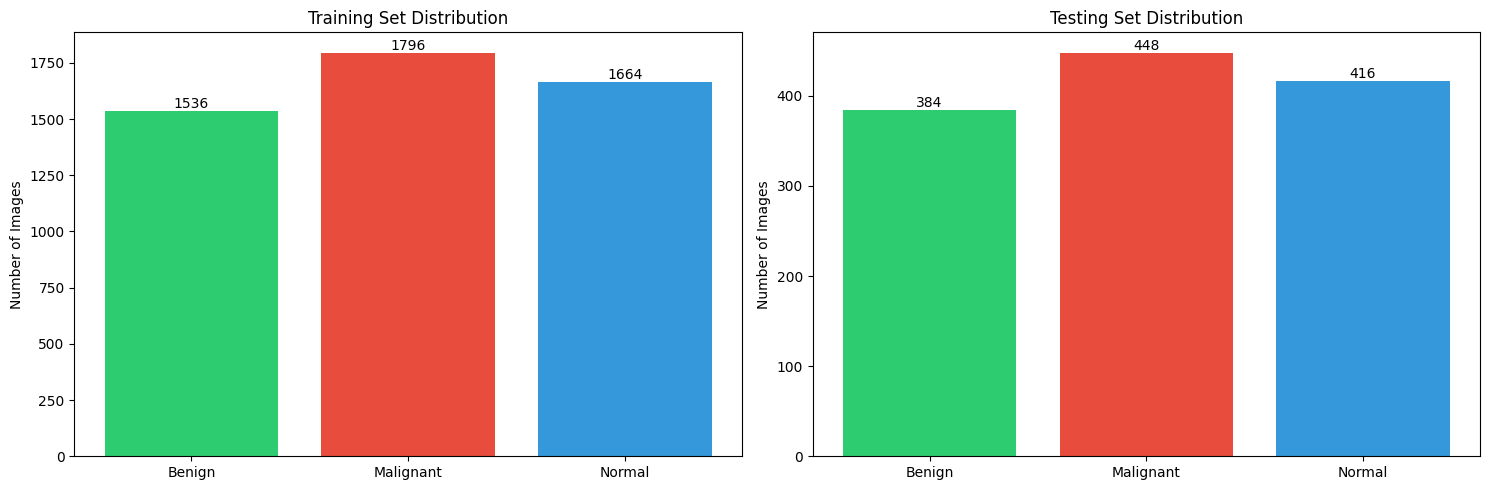


Training Set Distribution:
--------------------------------------------------
Benign: 1536 images (30.7%)
Malignant: 1796 images (35.9%)
Normal: 1664 images (33.3%)

Testing Set Distribution:
--------------------------------------------------
Benign: 384 images (30.8%)
Malignant: 448 images (35.9%)
Normal: 416 images (33.3%)

Train/Test Split Ratios per Class:
--------------------------------------------------
Benign: Train 80.0% / Test 20.0%
Malignant: Train 80.0% / Test 20.0%
Normal: Train 80.0% / Test 20.0%


In [ ]:
# Cell 1: Copy original images to augmented folders
import os
import shutil
from tqdm import tqdm

def copy_originals_to_augmented(source_base_path, dest_base_path):
    # Make sure destination directories exist
    for class_name in ['Benign', 'Malignant', 'Normal']:
        dest_path = os.path.join(dest_base_path, class_name)
        os.makedirs(dest_path, exist_ok=True)

        # Copy images
        source_path = os.path.join(source_base_path, class_name)
        files = [f for f in os.listdir(source_path) if f.endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]

        print(f"\nCopying {len(files)} original images for {class_name}")
        for file in tqdm(files):
            source_file = os.path.join(source_path, file)
            dest_file = os.path.join(dest_path, file)
            shutil.copy2(source_file, dest_file)

# Set paths
original_path = "/content/drive/MyDrive/Research Projects/Lung Cancer/train"
augmented_path = "/content/drive/MyDrive/Research Projects/Lung Cancer/augmented_train"

# Copy original images
copy_originals_to_augmented(original_path, augmented_path)


# Cell 2: Create test split

import os
import shutil
import random
import numpy as np

def create_test_split(source_path, test_path, test_ratio=0.2):
    # Create test directories
    for class_name in ['Benign', 'Malignant', 'Normal']:
        os.makedirs(os.path.join(test_path, class_name), exist_ok=True)

        # Get all images from source
        source_class_path = os.path.join(source_path, class_name)
        files = [f for f in os.listdir(source_class_path)
                if f.endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]

        # Calculate number of test images
        n_test = int(len(files) * test_ratio)

        # Randomly select test images
        test_files = random.sample(files, n_test)

        print(f"\nMoving {len(test_files)} images to test set for {class_name}")
        # Move selected files to test directory
        for file in tqdm(test_files):
            source_file = os.path.join(source_class_path, file)
            dest_file = os.path.join(test_path, class_name, file)
            shutil.move(source_file, dest_file)

# Set paths
augmented_path = "/content/drive/MyDrive/Research Projects/Lung Cancer/augmented_train"
test_path = "/content/drive/MyDrive/Research Projects/Lung Cancer/augmented_test"

# Create test split
create_test_split(augmented_path, test_path, test_ratio=0.2)





## Dataset Distribution After Augmentation

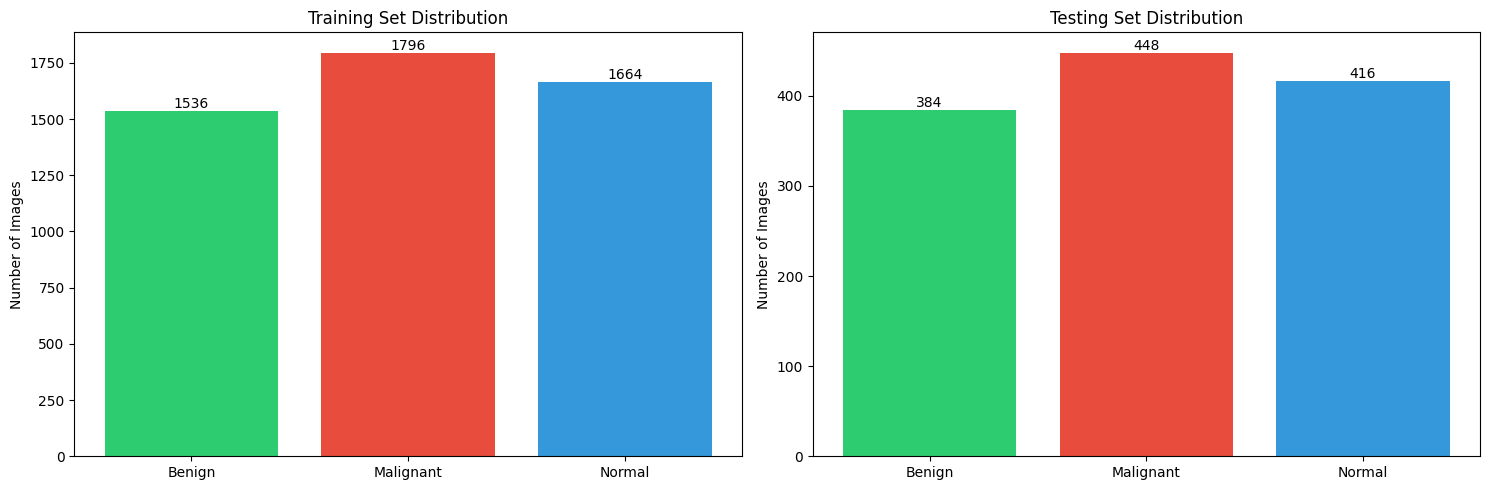


Training Set Distribution:
--------------------------------------------------
Benign: 1536 images (30.7%)
Malignant: 1796 images (35.9%)
Normal: 1664 images (33.3%)

Testing Set Distribution:
--------------------------------------------------
Benign: 384 images (30.8%)
Malignant: 448 images (35.9%)
Normal: 416 images (33.3%)

Train/Test Split Ratios per Class:
--------------------------------------------------
Benign: Train 80.0% / Test 20.0%
Malignant: Train 80.0% / Test 20.0%
Normal: Train 80.0% / Test 20.0%


In [ ]:
# Plot distribution

def count_images(path):
    counts = {}
    for class_name in ['Benign', 'Malignant', 'Normal']:
        class_path = os.path.join(path, class_name)
        counts[class_name] = len([f for f in os.listdir(class_path)
                                if f.endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))])
    return counts

# Count images in both sets
train_counts = count_images(augmented_path)
test_counts = count_images(test_path)

# Create bar plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Colors for the bars
colors = ['#2ecc71', '#e74c3c', '#3498db']

# Training set distribution
classes = list(train_counts.keys())
values = list(train_counts.values())
bars1 = ax1.bar(classes, values, color=colors)
ax1.set_title('Training Set Distribution')
ax1.set_ylabel('Number of Images')

# Add value labels on the bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

# Testing set distribution
test_values = list(test_counts.values())
bars2 = ax2.bar(classes, test_values, color=colors)
ax2.set_title('Testing Set Distribution')
ax2.set_ylabel('Number of Images')

# Add value labels on the bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print numerical distribution
print("\nTraining Set Distribution:")
print("-" * 50)
total_train = sum(train_counts.values())
for class_name, count in train_counts.items():
    percentage = (count/total_train) * 100
    print(f"{class_name}: {count} images ({percentage:.1f}%)")

print("\nTesting Set Distribution:")
print("-" * 50)
total_test = sum(test_counts.values())
for class_name, count in test_counts.items():
    percentage = (count/total_test) * 100
    print(f"{class_name}: {count} images ({percentage:.1f}%)")

# Print split ratios
print("\nTrain/Test Split Ratios per Class:")
print("-" * 50)
for class_name in classes:
    train_count = train_counts[class_name]
    test_count = test_counts[class_name]
    total = train_count + test_count
    train_ratio = (train_count / total) * 100
    test_ratio = (test_count / total) * 100
    print(f"{class_name}: Train {train_ratio:.1f}% / Test {test_ratio:.1f}%")

## Random Images per class

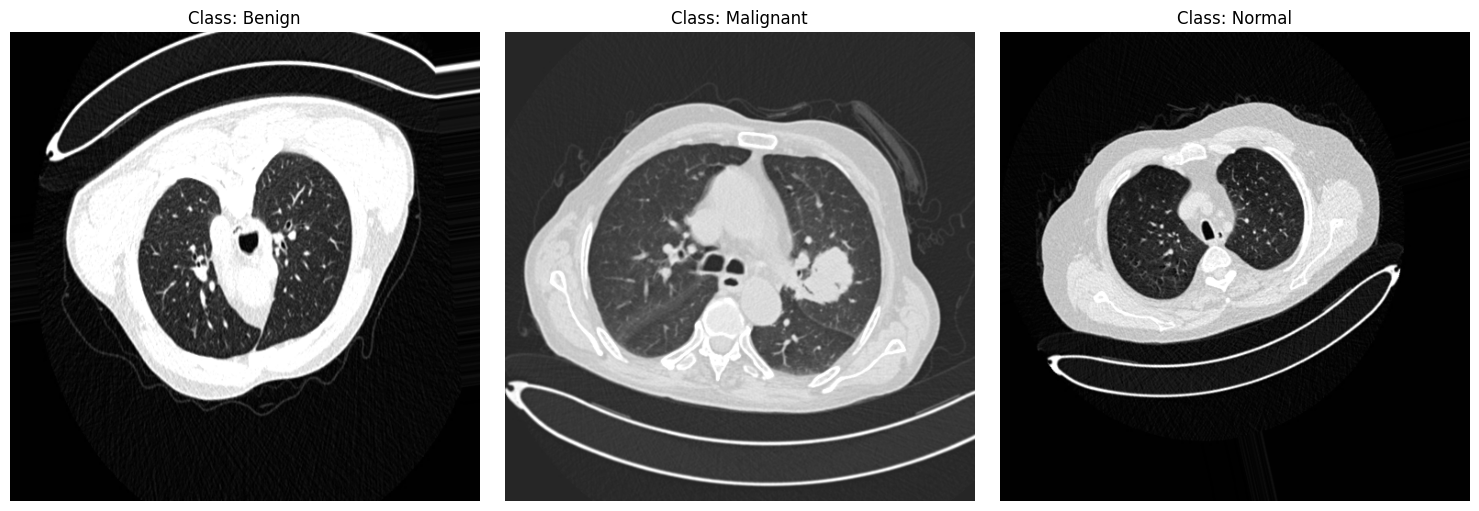

In [ ]:
# Display random images from each class
import os
import random
import matplotlib.pyplot as plt
import cv2

def display_random_images(base_path, classes):
    plt.figure(figsize=(15, 5))

    for idx, class_name in enumerate(classes, 1):
        # Get path to class directory
        class_path = os.path.join(base_path, class_name)

        # Get list of all images in the class
        images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff'))]

        # Select a random image
        random_image = random.choice(images)
        image_path = os.path.join(class_path, random_image)

        # Read and display the image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

        plt.subplot(1, 3, idx)
        plt.imshow(img)
        plt.title(f'Class: {class_name}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Path to training data
train_path = "/content/drive/MyDrive/Research Projects/Lung Cancer/augmented_train"

# Classes to display
classes = ['Benign', 'Malignant', 'Normal']

# Display random images
display_random_images(train_path, classes)

## Data Preprocessing and Augmentation

In [ ]:
# Set up paths and configurations
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
train_path = "/content/drive/MyDrive/Research Projects/Lung Cancer/augmented_train"
test_path = "/content/drive/MyDrive/Research Projects/Lung Cancer/augmented_test"

# Configuration class
class Config:
    img_height = 224
    img_width = 224
    batch_size = 32
    validation_split = 0.2

config = Config()

# Training data generator with only rescaling and validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=config.validation_split
)

# Test data generator (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data with validation split
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(config.img_height, config.img_width),
    batch_size=config.batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(config.img_height, config.img_width),
    batch_size=config.batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(config.img_height, config.img_width),
    batch_size=config.batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

# Print information about the generators
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"Classes: {class_names}")
print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Calculate class weights for handling any remaining imbalance
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get class distribution
train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weight_dict = dict(enumerate(class_weights))
print("\nClass weights:")
for class_name, weight in zip(class_names, class_weights):
    print(f"{class_name}: {weight:.2f}")

Found 3998 images belonging to 3 classes.
Found 998 images belonging to 3 classes.
Found 1248 images belonging to 3 classes.
Classes: ['Benign', 'Malignant', 'Normal']

Training samples: 3998
Validation samples: 998
Test samples: 1248

Class weights:
Benign: 1.08
Malignant: 0.93
Normal: 1.00


# Model Initialization Resnet50

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# Configuration
class Config:
    img_height = 224
    img_width = 224
    batch_size = 32
    epochs = 100
    learning_rate = 1e-4
    validation_split = 0.2

config = Config()

def create_model():
    # Load the ResNet50 model
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(config.img_height, config.img_width, 3)
    )

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Create the model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),  # Added BatchNorm
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),  # Added BatchNorm
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(3, activation='softmax')
    ])

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create model
model = create_model()

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# Train the model
history = model.fit(
    train_generator,
    epochs=config.epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Save the history for plotting
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 68s 422ms/step - accuracy: 0.3622 - loss: 1.4493 - val_accuracy: 0.3597 - val_loss: 1.1083 - learning_rate: 1.0000e-04
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 353ms/step - accuracy: 0.4627 - loss: 1.1491 - val_accuracy: 0.5371 - val_loss: 0.9433 - learning_rate: 1.0000e-04
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 352ms/step - accuracy: 0.5097 - loss: 1.0619 - val_accuracy: 0.6112 - val_loss: 0.8519 - learning_rate: 1.0000e-04
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 355ms/step - accuracy: 0.5476 - loss: 0.9895 - val_accuracy: 0.6283 - val_loss: 0.7996 - learning_rate: 1.0000e-04
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 358ms/step - accuracy: 0.5586 - loss: 0.9674 - val_accuracy: 0.6463 - val_loss: 0.7731 - learning_rate: 1.0000e-04
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 356ms/step - accuracy: 0.5888 - loss: 0.9325 - val_accuracy: 0.6643 - val_loss: 0.7489 - learning_rate: 1.0000e-04
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━

## Model Training

## Plotting Training Output

In [ ]:
def plot_training_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.1f',
                xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.title('Confusion Matrix (%)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_roc_curves(y_test, y_score, classes):
    n_classes = len(classes)
    y_test_bin = tf.keras.utils.to_categorical(y_test, n_classes)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average (AUC = {roc_auc["micro"]:.2f})',
             linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'macro-average (AUC = {roc_auc["macro"]:.2f})',
             linestyle=':', linewidth=4)

    colors = ['blue', 'red', 'green']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i],
                 label=f'ROC curve of {classes[i]} (AUC = {roc_auc[i]:.2f})',
                 color=color, linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.show()


## Model Evaluation

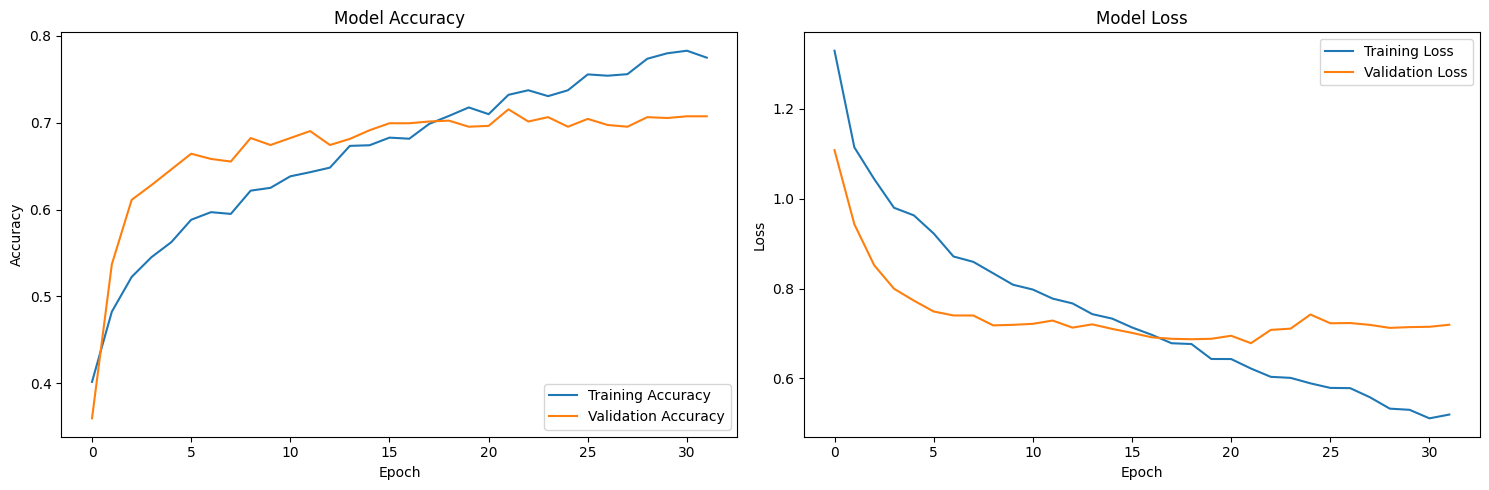

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 279ms/step - accuracy: 0.6222 - loss: 0.8467

Test accuracy: 0.6859


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 280ms/step


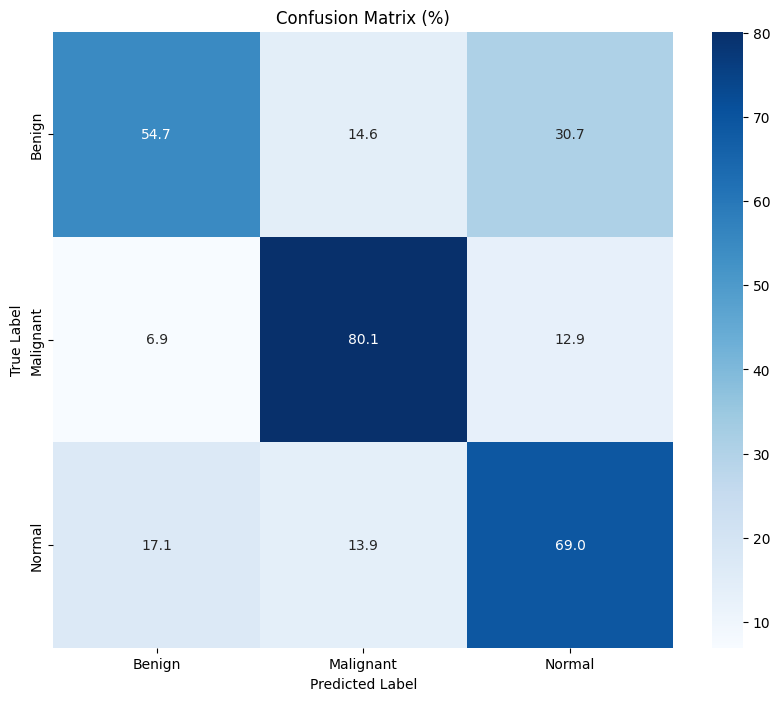

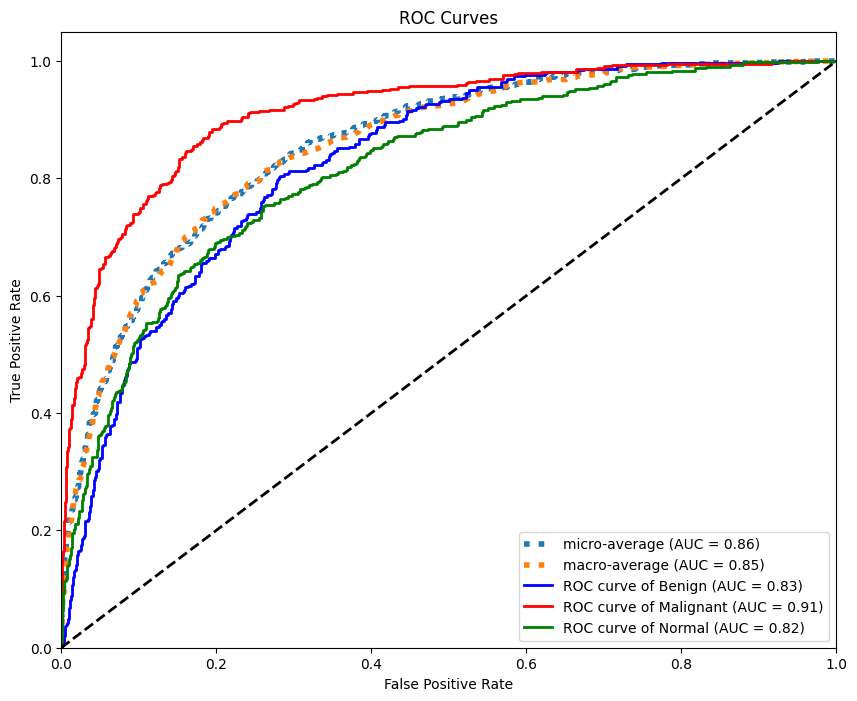

In [ ]:
# Plot training curves
plot_training_curves(history)

# Evaluate on test set
test_steps = test_generator.n // test_generator.batch_size + 1
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)
print(f'\nTest accuracy: {test_accuracy:.4f}')

# Get predictions
predictions = model.predict(test_generator, steps=test_steps)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)

# Plot ROC curves
plot_roc_curves(y_true, predictions, class_names)

## Precision | Recall | F1-Score

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 277ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


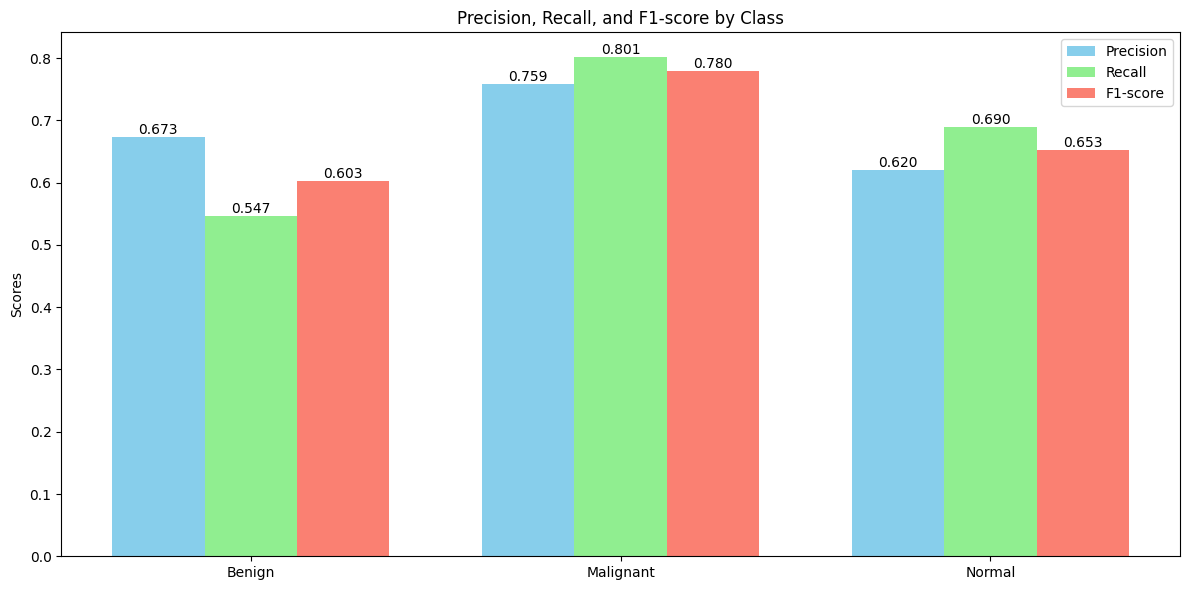


Detailed Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

      Benign       0.67      0.55      0.60       384
   Malignant       0.76      0.80      0.78       448
      Normal       0.62      0.69      0.65       416

    accuracy                           0.69      1248
   macro avg       0.68      0.68      0.68      1248
weighted avg       0.69      0.69      0.68      1248



In [ ]:
# Calculate and visualize performance metrics
from sklearn.metrics import classification_report, precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt

# Get predictions if you haven't already
test_steps = test_generator.n // test_generator.batch_size + 1
predictions = model.predict(test_generator, steps=test_steps)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Calculate metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

# Create bar plot
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(class_names))
width = 0.25

# Plot bars
bars1 = ax.bar(x - width, precision, width, label='Precision', color='skyblue')
bars2 = ax.bar(x, recall, width, label='Recall', color='lightgreen')
bars3 = ax.bar(x + width, f1, width, label='F1-score', color='salmon')

# Customize plot
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-score by Class')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()

# Add value labels on top of bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

plt.tight_layout()
plt.show()

# Print detailed classification report
print("\nDetailed Classification Report:")
print("-" * 50)
print(classification_report(y_true, y_pred, target_names=class_names))

## Save Model

In [ ]:
# Saving the final model with .keras extension
model.save('/content/drive/MyDrive/Research Projects/Lung Cancer/Outcomelung_cancer_efficientnet_0_6856.keras')

## Model  Fine-tuning

In [ ]:
# Unfreeze the top layers of the base model
base_model = model.layers[0]
base_model.trainable = True

# Freeze all layers except the last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model again
history_fine = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Save fine-tuned model
model.save('/content/drive/MyDrive/lung_cancer_resnet50_finetuned.h5')